In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K

# Layers for training
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

# Losses for training
from tensorflow.keras import losses

# Data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

### 載入資料集

In [32]:
# Load dataset
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

# Reshape size
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

# Normalize the range of featurs
x_train = x_train / x_train.max()
x_test = x_test / x_test.max()

# One-hot encoding
y_train_n及w = to_categorical(y_train, 10)
y_test_new = to_categorical(y_test, 10)

### 定義抽樣函數

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon    

### 設計神經網路架構

In [5]:
enc_1 = Dense(392, activation='sigmoid')
enc_2 = Dense(196, activation='sigmoid')
enc_3 = Dense(100, activation='relu')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_1 = Dense(100, activation='relu')
dec_2 = Dense(196, activation='sigmoid')
dec_3 = Dense(392, activation='sigmoid')
dec_4 = Dense(784, activation='sigmoid')

#### 定義Encoder

In [6]:
x = Input(shape=(784,))
enc_x = enc_3(enc_2(enc_1(x)))

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

#### 封包成Keras的Layer

In [7]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

#### 定義Decoder

In [8]:
x_hat = dec_4(dec_3(dec_2(dec_1(z))))

#### 模型建立

In [9]:
VAE = Model(x, x_hat)
VAE.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 392)          307720      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 196)          77028       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          19700       dense_1[0][0]                    
______________________________________________________________________________________________

In [10]:
# reconstruction_loss = tf.keras.losses.mse(inputs, outputs)
reconstruction_loss = 784 * losses.binary_crossentropy(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

### 訓練模型

In [11]:
VAE.compile(optimizer=Adam())

In [17]:
VAE.fit(x_train, 
        batch_size=512, 
        epochs=20)

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 8s 129us/sample - loss: 223.6661
Epoch 2/20
60000/60000 [==============================] - 6s 95us/sample - loss: 202.0268
Epoch 3/20
60000/60000 [==============================] - 6s 101us/sample - loss: 193.2081
Epoch 4/20
60000/60000 [==============================] - 6s 107us/sample - loss: 190.1145
Epoch 5/20
60000/60000 [==============================] - 6s 103us/sample - loss: 188.1692
Epoch 6/20
60000/60000 [==============================] - 6s 99us/sample - loss: 185.8912
Epoch 7/20
60000/60000 [==============================] - 6s 100us/sample - loss: 178.5908
Epoch 8/20
60000/60000 [==============================] - 6s 100us/sample - loss: 173.5993
Epoch 9/20
60000/60000 [==============================] - 6s 98us/sample - loss: 169.8524
Epoch 10/20
60000/60000 [==============================] - 6s 107us/sample - loss: 167.3040
Epoch 11/20
60000/60000 [==============================] - 7s 122us/s

### Encoder視覺化

In [18]:
VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 392)               307720    
_________________________________________________________________
dense_1 (Dense)              (None, 196)               77028     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               19700     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 404,650
Trainable params: 404,650
Non-trainable params: 0
_________________________________________________________________


In [19]:
idx = np.random.randint(x_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {VAE_Encoder.predict(x_train[idx: idx+1]).squeeze()}")

第 59291 圖的 latent 表示為 [-0.41204515 -0.825155  ]


In [34]:
indices = np.random.randint(x_train.shape[0], size=3000)
VAE_latents = VAE_Encoder.predict(x_train[indices])

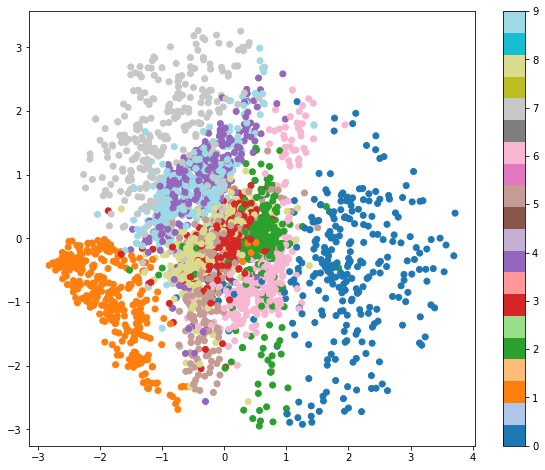

In [35]:
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train[indices], cmap='tab20')
plt.colorbar()
plt.show()

### Decoder視覺化

In [37]:
z_input = Input(shape=(2,))

In [40]:
VAE_Decoder = Model(z_input, dec_4(dec_3(dec_2(dec_1(z_input)))))
VAE_Decoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_6 (Dense)              (None, 196)               19796     
_________________________________________________________________
dense_7 (Dense)              (None, 392)               77224     
_________________________________________________________________
dense_8 (Dense)              (None, 784)               308112    
Total params: 405,432
Trainable params: 405,432
Non-trainable params: 0
_________________________________________________________________


In [41]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [48]:
n = 30
digit_size = 28

grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

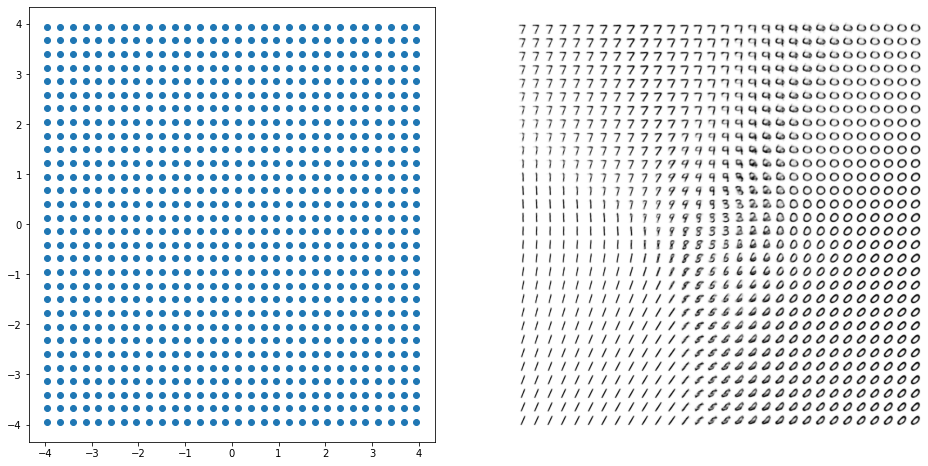

In [49]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

### 動態比較

In [50]:
idx_1, idx_2 = np.random.randint(x_train.shape[0], size=2)

In [51]:
def inBetween(t):
    data_0 = x_train[idx_1].reshape(28, 28)
    data_1 = x_train[idx_2].reshape(28, 28)
    data_t = (1-t)*data_0 + t*data_1
    
    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('t=0')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title(f't={t}')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('t=1')

In [52]:
interact(inBetween, t=FloatSlider(value=0, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>